# Sarima Argentina

Aplicação do modelo Sarima para o número de mortes da Argentina

In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Argentina.csv'
serie_arg = pd.read_csv(url) 
serie_arg.drop('Unnamed: 0',axis=1,inplace=True)
serie_arg['Date'] = pd.to_datetime(serie_arg['Date'],format='%Y-%m-%d')
serie_arg['Mês'] = serie_arg['Date'].dt.month
serie_arg.set_index('Date',inplace=True)
serie_arg.head()

,Confirmed,Recovered,Deaths,Ano,Mês
Date,,,,,
2020-01-22,0,0.0,0,2020,1
2020-01-23,0,0.0,0,2020,1
2020-01-24,0,0.0,0,2020,1
2020-01-25,0,0.0,0,2020,1
2020-01-26,0,0.0,0,2020,1


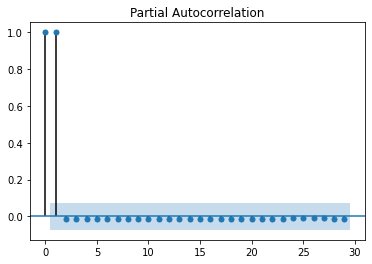

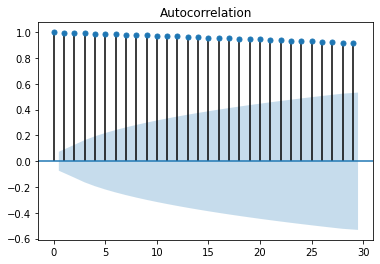

In [ ]:
plot_pacf(serie_arg['Deaths']);
plot_acf(serie_arg['Deaths']);

In [ ]:
# Separação entre treino e teste
treino = serie_arg[(serie_arg['Ano']<=2021)&(serie_arg['Mês']<12)]
teste = serie_arg[(serie_arg['Ano']==2021)&(serie_arg['Mês'] == 12)]

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 1)",16.000000
1,"(1, 1, 0, 1)",8849.341135
2,"(2, 1, 2, 3)",8850.667795
3,"(2, 1, 0, 1)",8850.905345
4,"(1, 2, 0, 1)",8850.905599
...,...,...
250,"(3, 0, 0, 0)",9237.691487
251,"(0, 0, 0, 0)",9239.614139
252,"(0, 1, 0, 0)",9240.083076
253,"(1, 0, 0, 0)",9240.180629


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 1, 1), seasonal_order=(3, 1, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Deaths   No. Observations:                  648
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 4)   Log Likelihood               -4420.806
Date:                           Thu, 15 Dec 2022   AIC                           8855.612
Time:                                   22:50:46   BIC                           8886.875
Sample:                                        0   HQIC                          8867.744
                                           - 648                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.009    112.758      0.000       0.982       1.017
ma.L1         -0.9135      0.019    -49.362

In [ ]:
fc = best_model.forecast(31, alpha=0.05)

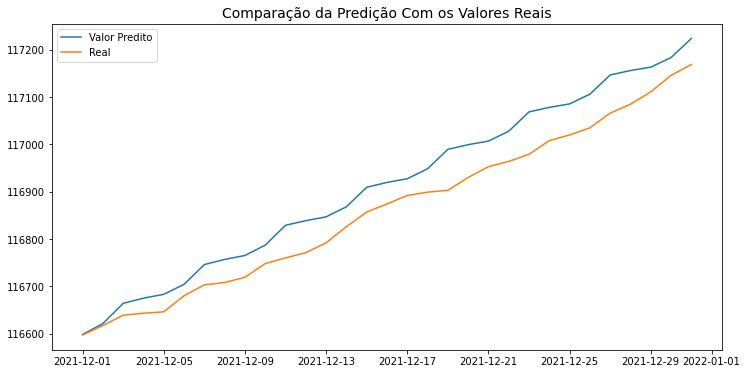

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.000437017564992516
MAE: 51.089741398155084
RMSE: 55.22388837099578
